# Track filtering/fitting with LSTMs and Gaussian predictions

This is a continuous space model using the ACTS data.
Like the LSTMTrackFilter notebook, it predicts the location of the next hit given a hit sequence.
However, unlike the previous model, we now produce a probability distribution in the form of a multivariate Gaussian.

This lets our model quantify uncertainty and score hits in a more meaningful way.

In this notebook we load a pre-trained model and simply make some evaluation plots.

In [1]:
from __future__ import print_function

# System imports
import os

# Data libraries
import numpy as np
import pandas as pd
from scipy.stats import norm, multivariate_normal

# Torch imports
import torch

# Visualization
import matplotlib.pyplot as plt

# Local imports
import torchutils
torchutils.set_cuda(False)
from torchutils import np_to_torch, torch_to_np
from track_filter import coord_scale

# Magic
%matplotlib notebook

## Read the data

In [2]:
def prepare_model_data(data):
    """
    Put a chunk of numpy data into format for the model.
    Reshapes and slices out the input and target features,
    and converts into PyTorch Variable format.    
    """
    # All but last detector layer used as inputs
    inputs = np_to_torch(data[:, :-1])
    # Target includes all but first layer, and drops the layer feature
    targets = np_to_torch(data[:, 1:, :-1])
    return inputs, targets

In [3]:
data_dir = '/global/cscratch1/sd/sfarrell/heptrkx/filter_data_005'
train_dir = '/global/cscratch1/sd/sfarrell/heptrkx/RNNGausFilter_20171215_1130'
model_file = os.path.join(train_dir, 'model')
losses_file = os.path.join(train_dir, 'losses.npz')

In [5]:
#train_data = np.load(os.path.join(data_dir, 'train_data.npy'))
test_data = np.load(os.path.join(data_dir, 'test_data.npy'))

losses_data = np.load(losses_file)
train_losses = losses_data['train_losses']
valid_losses = losses_data['valid_losses']

# Load the pre-trained model
model = torch.load(model_file)
model.eval()
model

HitGausPredictor(
  (lstm): LSTM(3, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=5)
)

In [6]:
# Prepare data into input/output
test_input, test_target = prepare_model_data(test_data)

## Loss curves

<IPython.core.display.Javascript object>


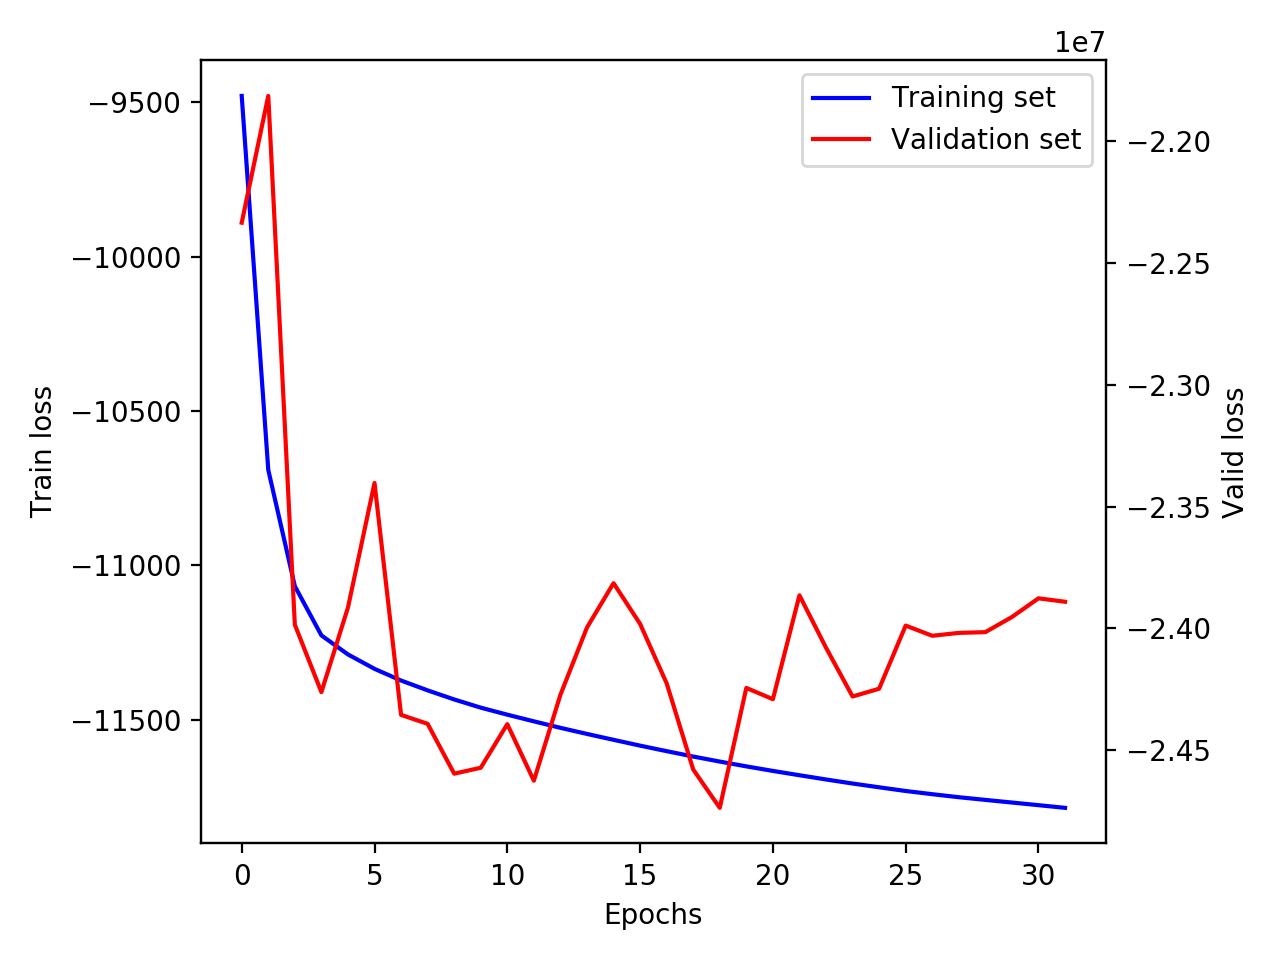

In [8]:
plt.figure()
p1, = plt.plot(np.array(train_losses), c='b', label='Training set')
plt.ylabel('Train loss')
plt.xlabel('Epochs')
plt.twinx()
p2, = plt.plot(np.array(valid_losses), c='r', label='Validation set')
plt.ylabel('Valid loss')
plt.legend([p1, p2], ['Training set', 'Validation set'])
plt.tight_layout()

## Evaluate model performance

Understanding the loss is a bit difficult. I need to provide some additional metrics.

In [9]:
test_output = model(test_input)

### Visualizing predictions

In [10]:
cov_scale = coord_scale[:2, None] * coord_scale[None, :2]

<IPython.core.display.Javascript object>


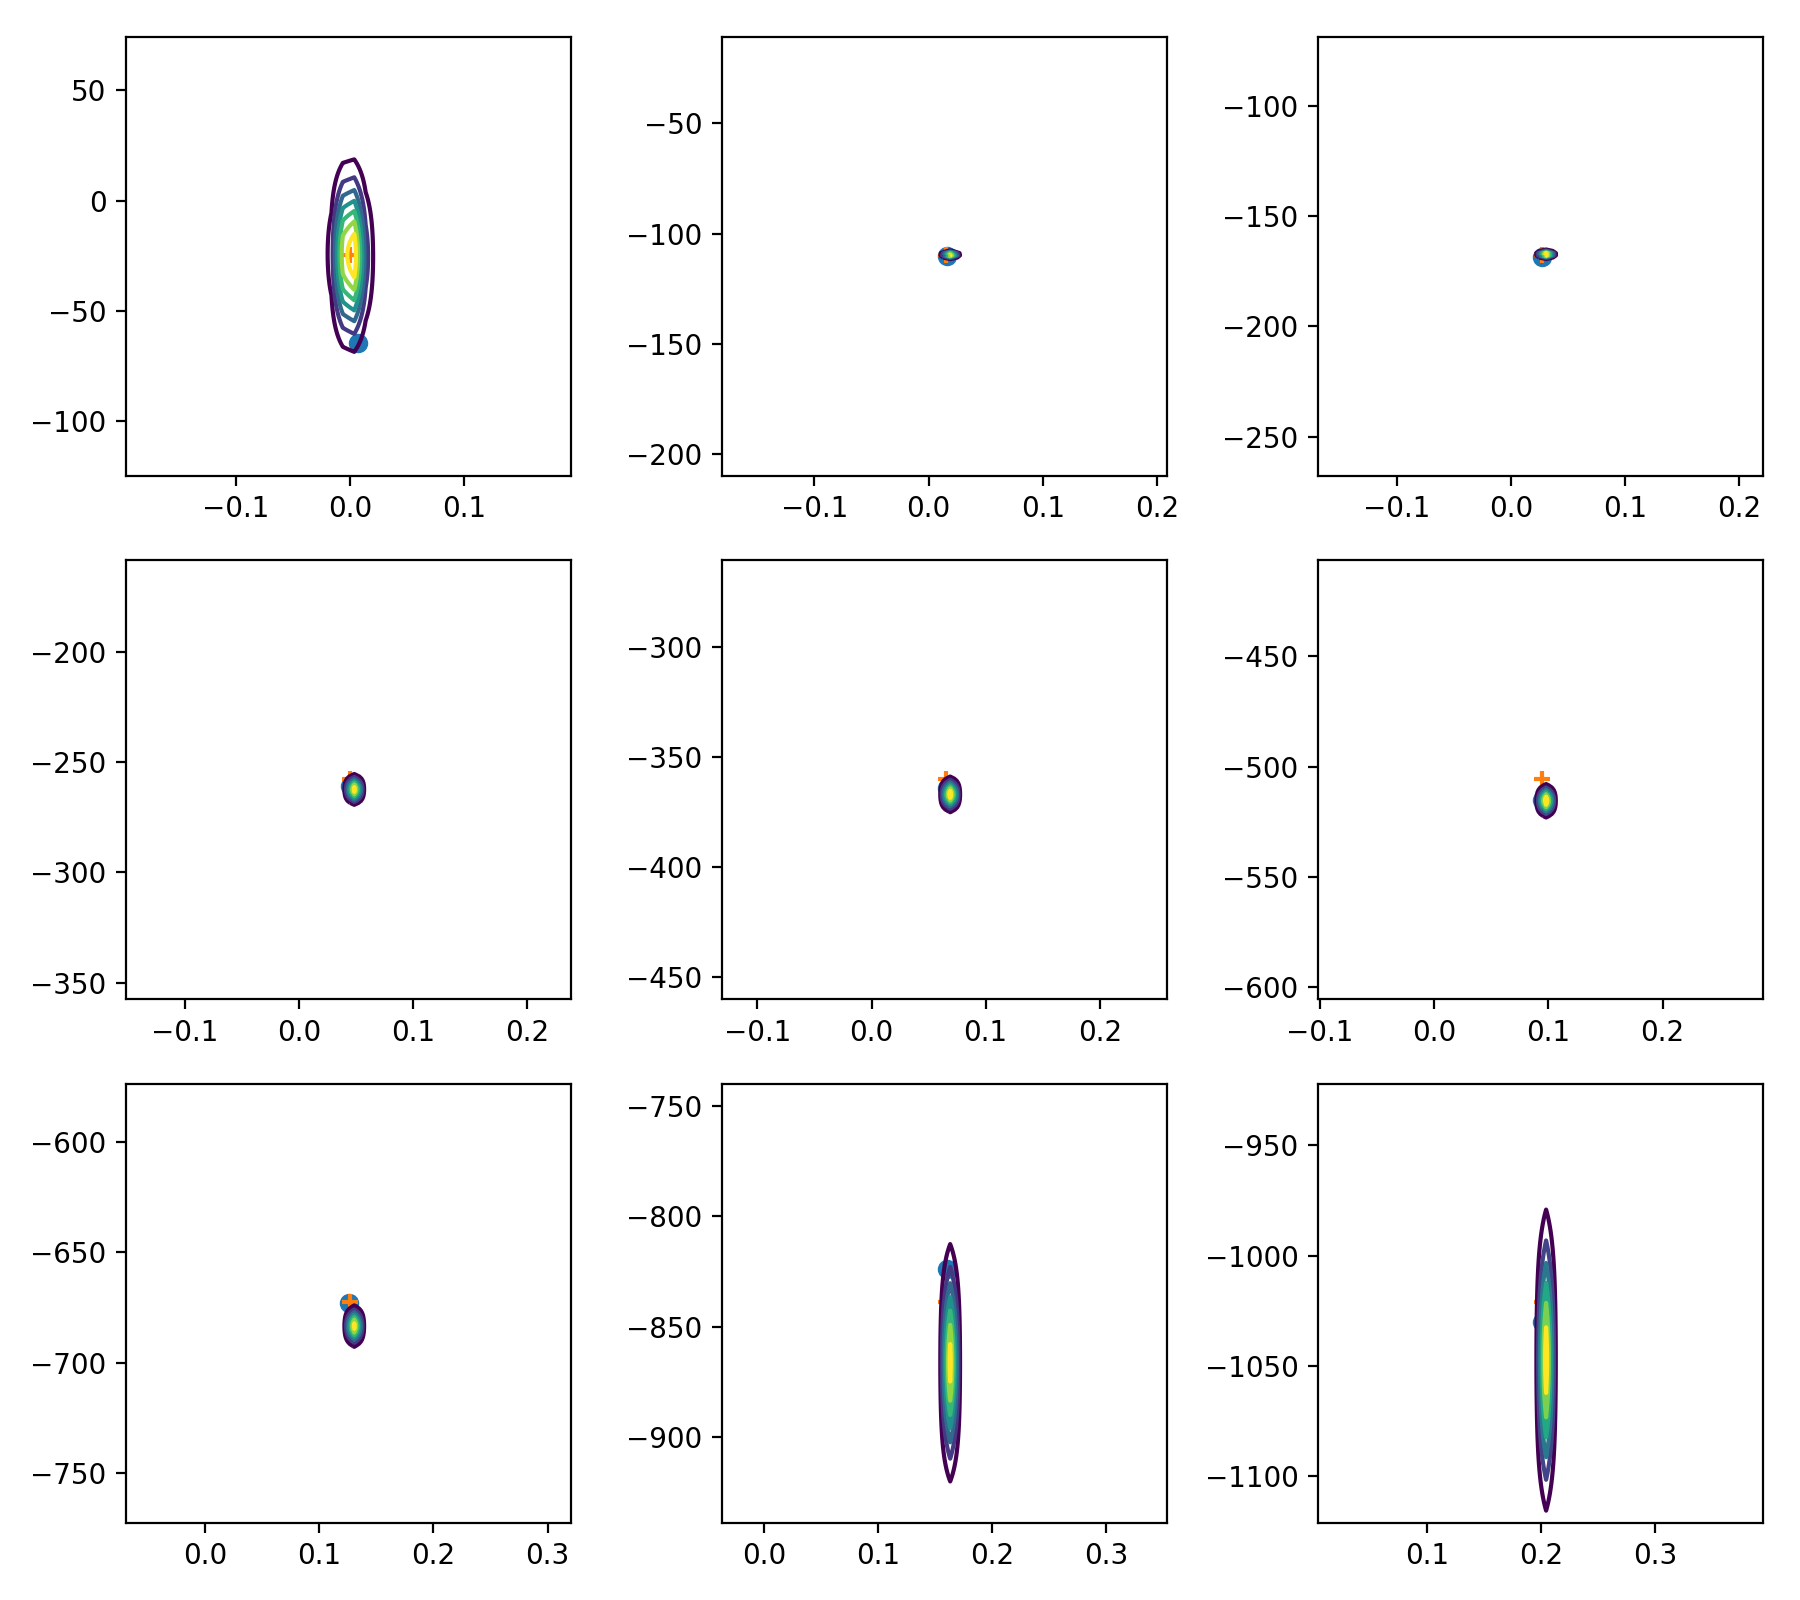

In [11]:
# Pick out the values to draw
isample = 0
mus = torch_to_np(test_output[0][isample]) * coord_scale[:2]
covs = torch_to_np(test_output[1][isample]) * cov_scale
targets = torch_to_np(test_target[isample]) * coord_scale[:2]

# Draw figure with 9 subplots (3x3) for the predictions on each layer
plt.figure(figsize=(9,8))

for ilay in range(9):
    plt.subplot(3, 3, ilay+1)
    # Construct a gaussian from our prediction
    pred = multivariate_normal(mus[ilay], covs[ilay])
    
    # Compute values on a grid
    wsize = np.array([np.pi/16, 100])
    wlow, whigh = mus[ilay] - wsize, mus[ilay] + wsize
    phi_grid, z_grid = np.mgrid[wlow[0]:whigh[0]:.01, wlow[1]:whigh[1]:1]
    pred_grid = pred.pdf(np.dstack([phi_grid, z_grid]))
    
    # Draw the predicted gaussian
    c = plt.contour(phi_grid, z_grid, pred_grid)
    # Draw the actual hit location
    plt.scatter(targets[ilay, 0], targets[ilay, 1])
    # Draw the mean prediction
    plt.scatter(mus[ilay, 0], mus[ilay, 1], marker='+')

plt.tight_layout()

<IPython.core.display.Javascript object>


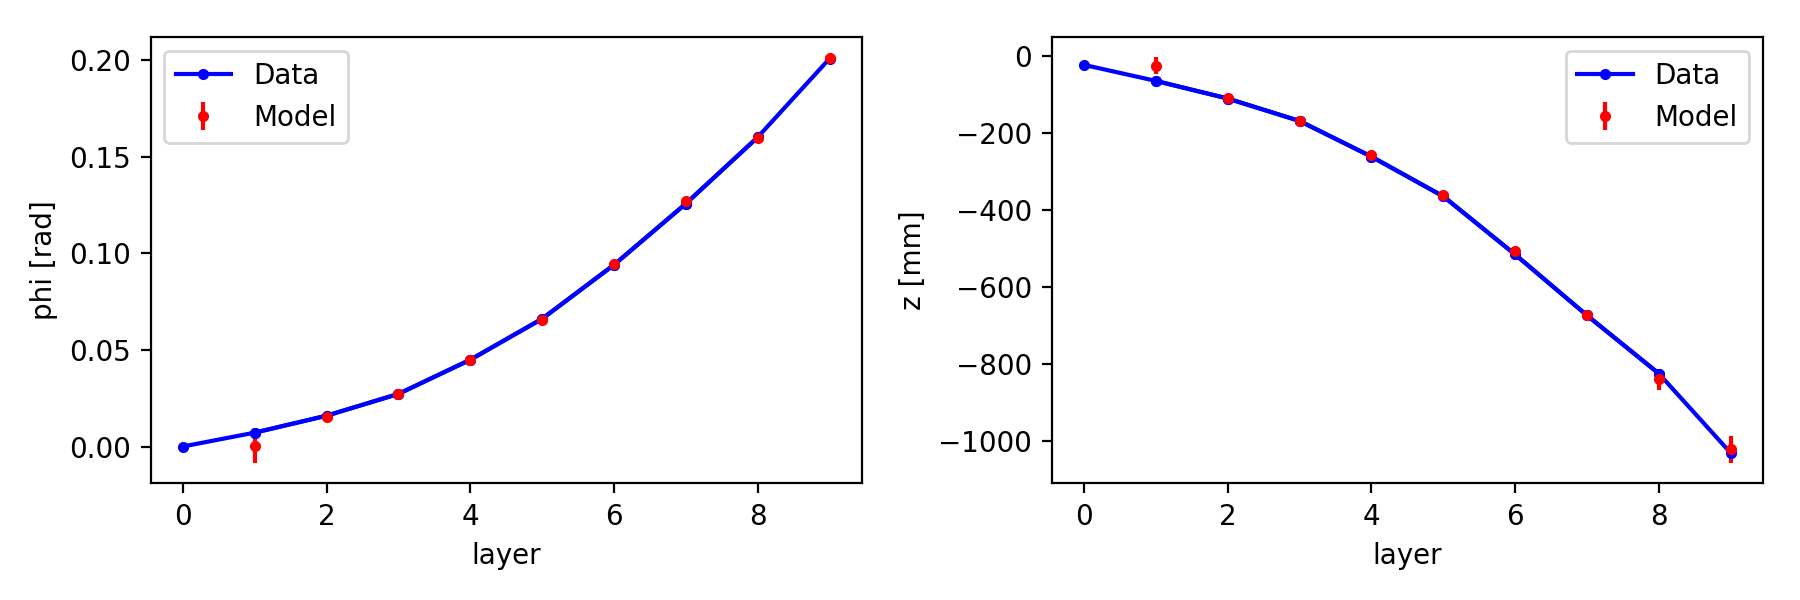

<IPython.core.display.Javascript object>


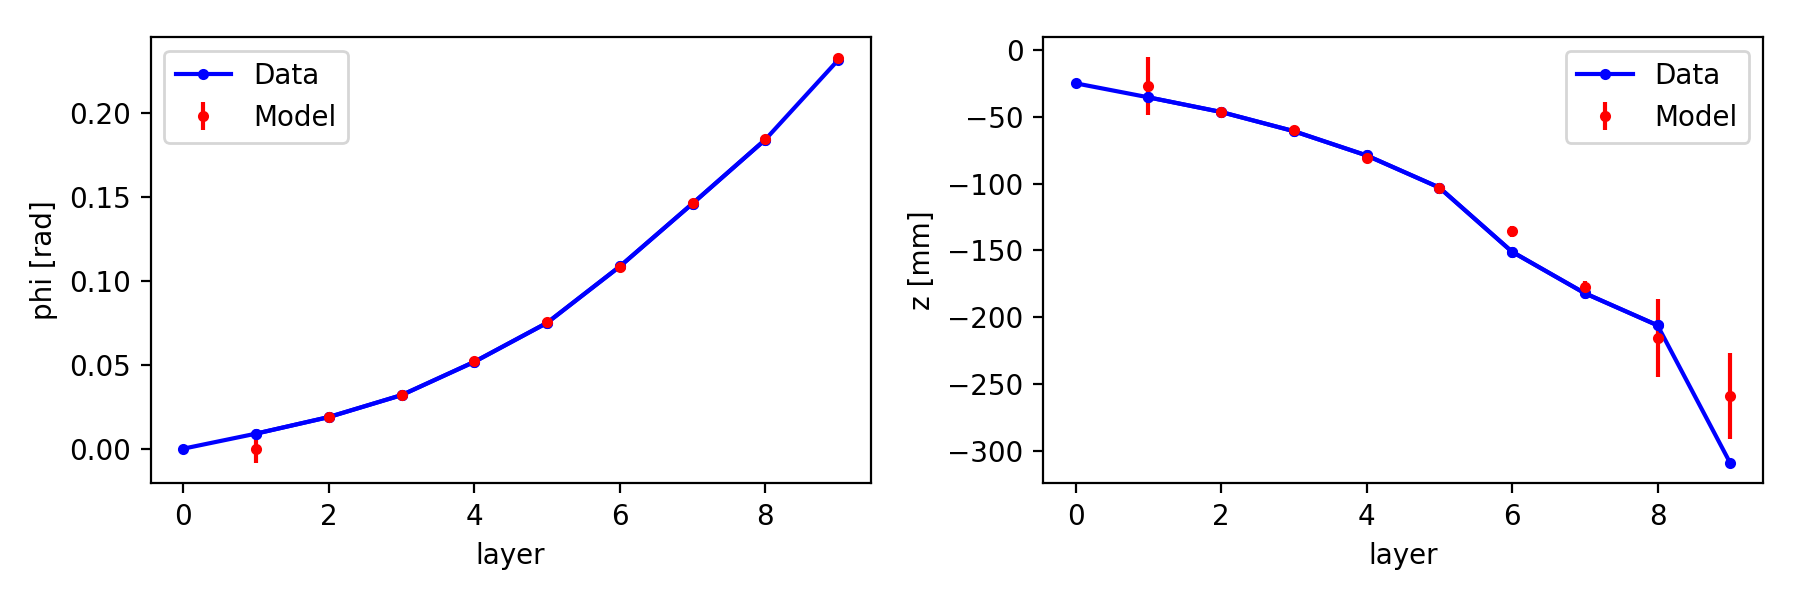

<IPython.core.display.Javascript object>


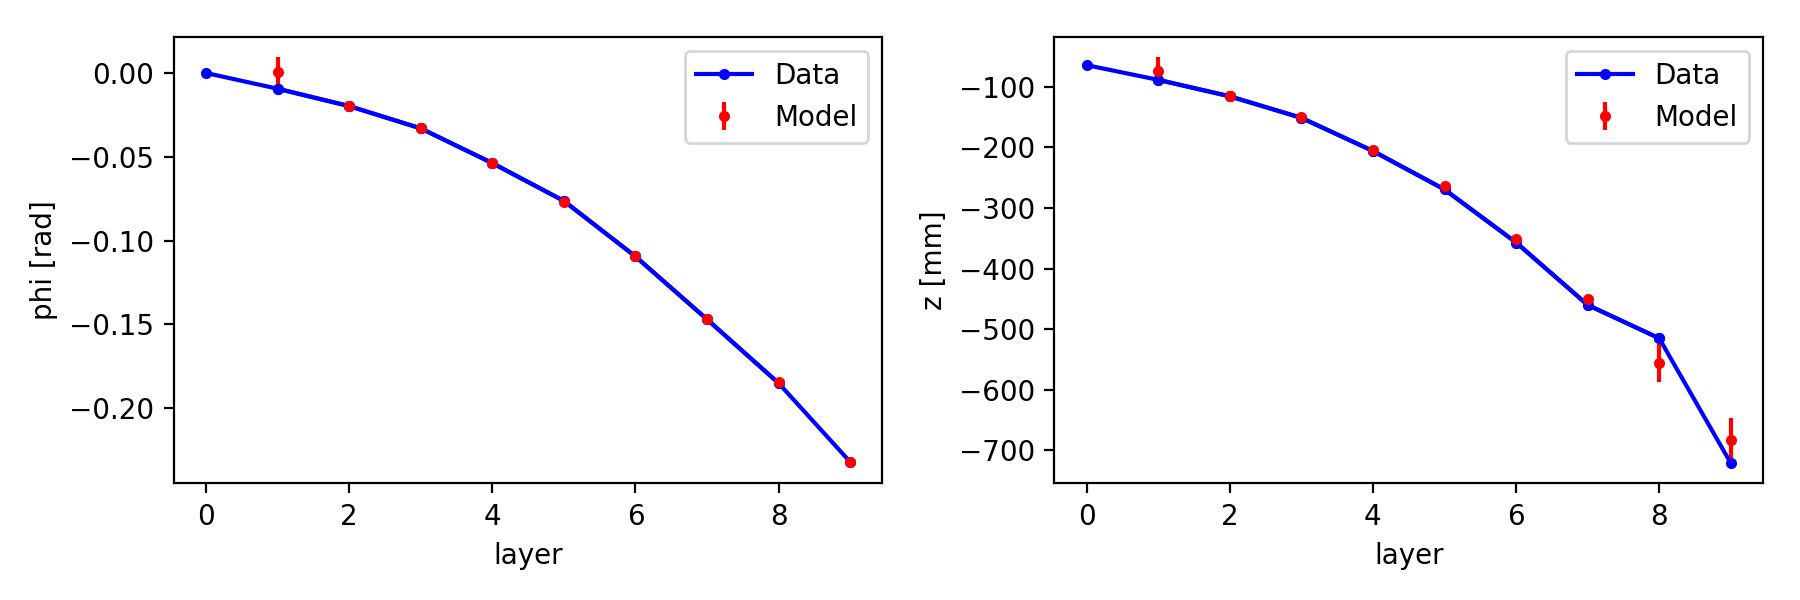

<IPython.core.display.Javascript object>


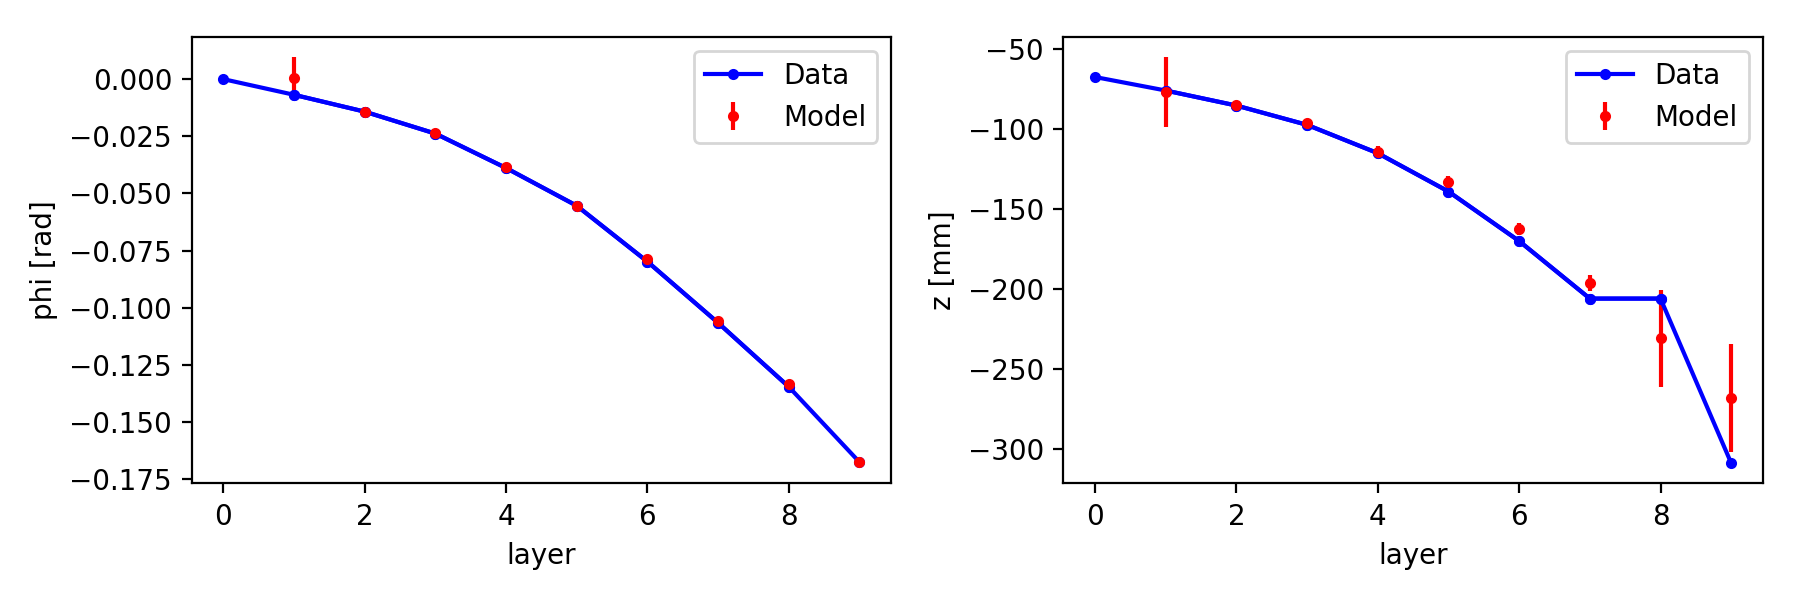

In [12]:
layers = np.arange(10)

# Loop over a few samples to draw
for isample in range(4):

    inputs = torch_to_np(test_input[isample]) * coord_scale
    targets = torch_to_np(test_target[isample]) * coord_scale[:2]
    pred_mus = torch_to_np(test_output[0][isample]) * coord_scale[:2]
    pred_covs = torch_to_np(test_output[1][isample]) * cov_scale

    pred_phi = pred_mus[:, 0]
    pred_z = pred_mus[:, 1]
    pred_phi_sig = np.sqrt(pred_covs[:,0,0])
    pred_z_sig = np.sqrt(pred_covs[:,1,1])

    # Draw the means first
    plt.figure(figsize=(9,3))
    plt.subplot(121)
    plt.plot(layers[:-1], inputs[:, 0], 'b.-')
    plt.plot(layers[1:], targets[:,0], 'b.-', label='Data')
    plt.errorbar(layers[1:], pred_phi, yerr=pred_phi_sig, fmt='r.', label='Model')
    plt.xlabel('layer')
    plt.ylabel('phi [rad]')
    plt.legend(loc=0)

    plt.subplot(122)
    plt.plot(layers[:-1], inputs[:, 1], 'b.-')
    plt.plot(layers[1:], targets[:, 1], 'b.-', label='Data')
    plt.errorbar(layers[1:], pred_z, yerr=pred_z_sig, fmt='r.', label='Model')
    plt.xlabel('layer')
    plt.ylabel('z [mm]')
    plt.legend(loc=0)

    plt.tight_layout()

In [13]:
def calc_residuals(preds, targets):
    """
    Calculates the residuals errors for phi and z coordinates.
    Corrects for the delta-phi discontinuity.
    """
    res = preds - targets
    # fix the delta-phi calculation around the discontinuity
    res[res[:,:,0] > np.pi, 0] -= 2*np.pi
    res[res[:,:,0] < -np.pi, 0] += 2*np.pi
    return res

In [14]:
# Extract the test set data, errors, pulls
preds = torch_to_np(test_output[0]) * coord_scale[:2]
sigmas = np.sqrt(np.diagonal(torch_to_np(test_output[1]), axis1=2, axis2=3)) * coord_scale[:2]
targets = torch_to_np(test_target) * coord_scale[:2]
residuals = calc_residuals(preds, targets)
pulls = residuals / sigmas

In [15]:
# Fit the pull distributions
phi_pulls = pulls[:, :, 0].flatten()
z_pulls = pulls[:, :, 1].flatten()
fit_x = np.linspace(-5, 5)

phi_pull_mu, phi_pull_std = norm.fit(phi_pulls)
phi_pull_fit = norm.pdf(fit_x, phi_pull_mu, phi_pull_std)

z_pull_mu, z_pull_std = norm.fit(z_pulls)
z_pull_fit = norm.pdf(fit_x, z_pull_mu, z_pull_std)

<IPython.core.display.Javascript object>


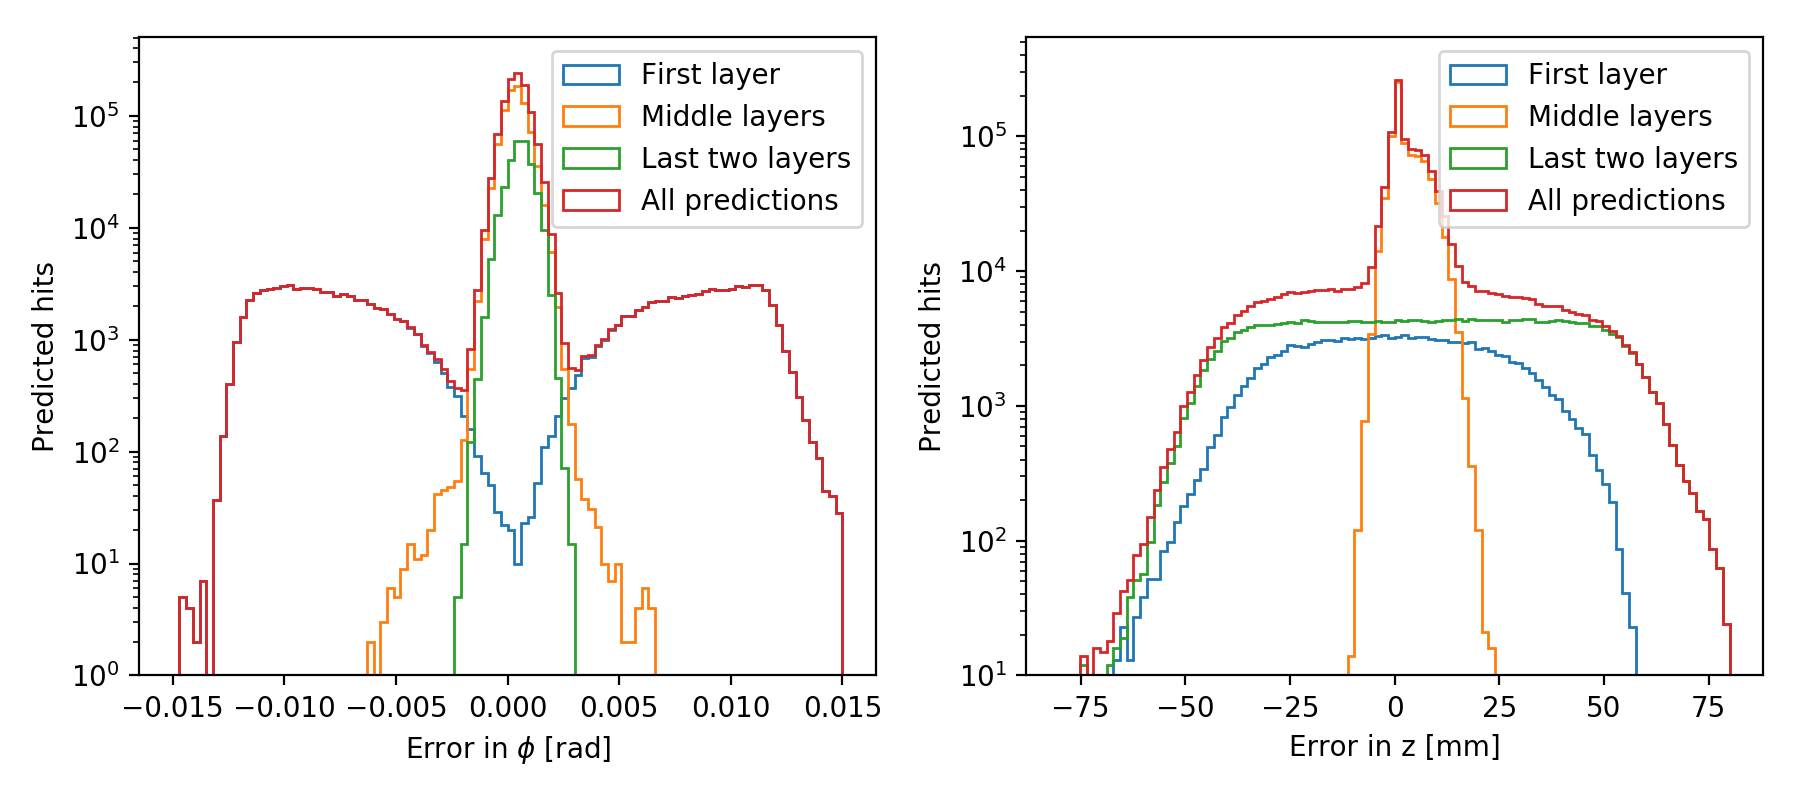

In [18]:
plt.figure(figsize=(9,4))
plt.subplot(121)
hist_args = dict(bins=100, range=(-0.015, 0.015),
                 normed=False, log=True, histtype='step')
# Draw errors on first, last, and all prediction layers separately
plt.hist(residuals[:,:1,0].flatten(), label='First layer', **hist_args)
plt.hist(residuals[:,1:-2,0].flatten(), label='Middle layers', **hist_args)
plt.hist(residuals[:,-2:,0].flatten(), label='Last two layers', **hist_args)
plt.hist(residuals[:,:,0].flatten(), label='All predictions', **hist_args)
plt.xlabel('Error in $\phi$ [rad]')
plt.ylabel('Predicted hits')
plt.ylim(ymin=1)
plt.legend(loc=0)

plt.subplot(122)
hist_args = dict(bins=100, range=(-80, 80),
                 normed=False, log=True, histtype='step')
plt.hist(residuals[:,:1,1].flatten(), label='First layer', **hist_args)
plt.hist(residuals[:,1:-2,1].flatten(), label='Middle layers', **hist_args)
plt.hist(residuals[:,-2:,1].flatten(), label='Last two layers', **hist_args)
plt.hist(residuals[:,:,1].flatten(), label='All predictions', **hist_args)
plt.xlabel('Error in z [mm]')
plt.ylabel('Predicted hits')
plt.ylim(ymin=10)
plt.legend(loc=0)
plt.tight_layout()

<IPython.core.display.Javascript object>


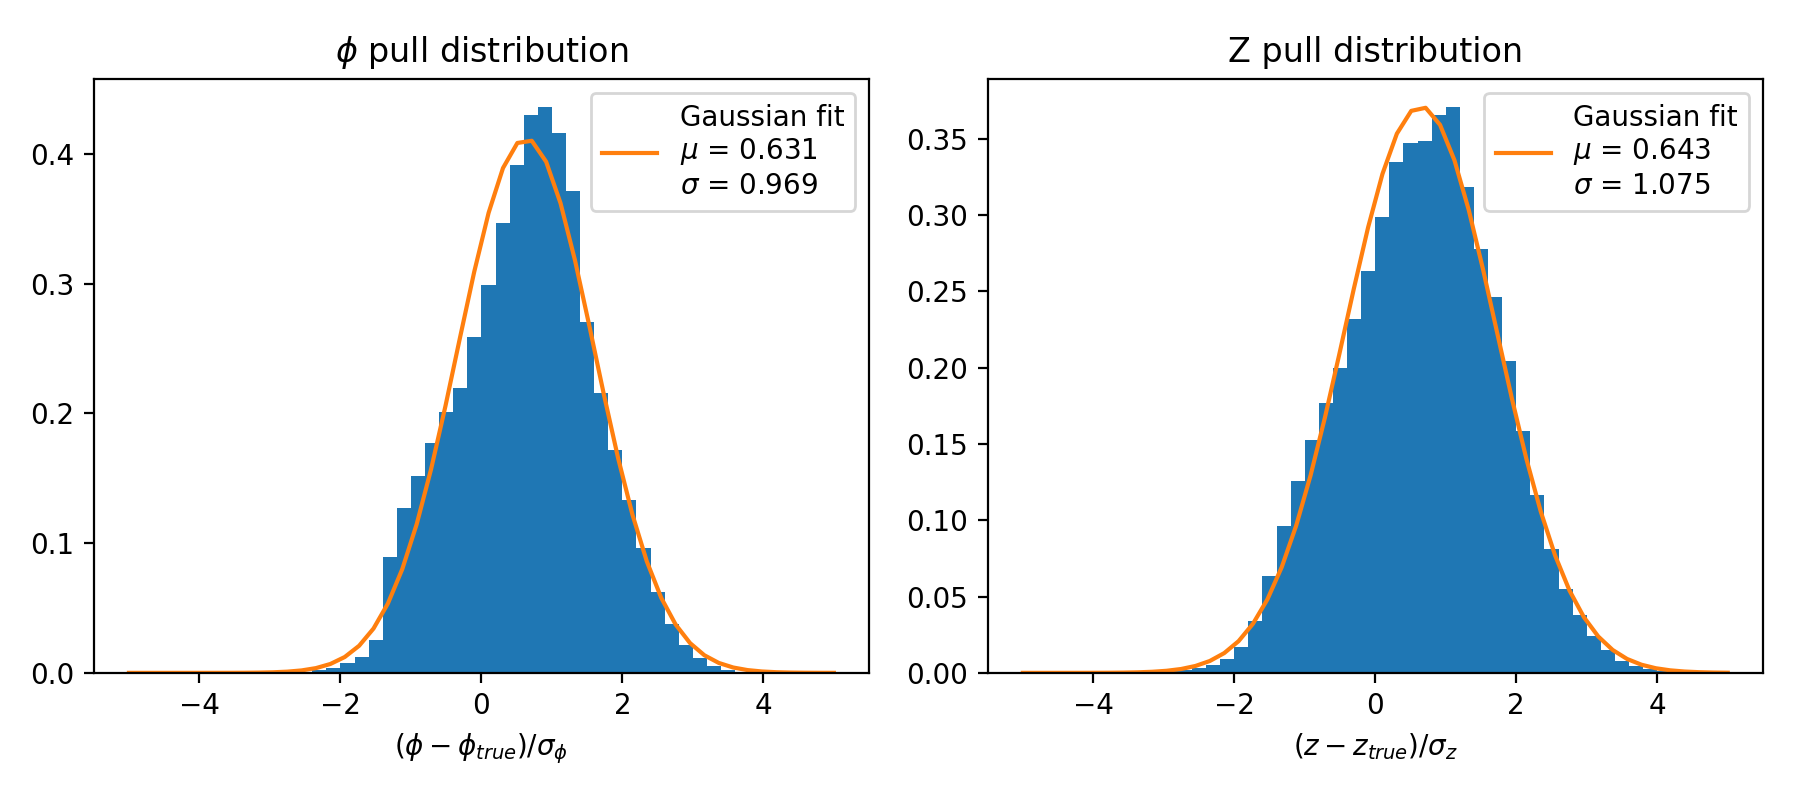

In [19]:
# Draw the pull distributions
plt.figure(figsize=(9,4))

plt.subplot(121)
plt.hist(phi_pulls, bins=50, range=[-5, 5], normed=True)
fit_label = 'Gaussian fit\n$\mu$ = %.3f\n$\sigma$ = %.3f' % (phi_pull_mu, phi_pull_std)
plt.plot(fit_x, phi_pull_fit, label=fit_label)
plt.xlabel('$(\phi - \phi_{true}) / \sigma_\phi$')
plt.title('$\phi$ pull distribution')
plt.legend(loc=0)

plt.subplot(122)
plt.hist(z_pulls, bins=50, range=[-5, 5], normed=True)
fit_label = 'Gaussian fit\n$\mu$ = %.3f\n$\sigma$ = %.3f' % (z_pull_mu, z_pull_std)
plt.plot(fit_x, z_pull_fit, label=fit_label)
plt.xlabel('$(z - z_{true}) / \sigma_z$')
plt.title('Z pull distribution')
plt.legend(loc=0)

plt.tight_layout()

## Discussion

This model seems to be able to learn trajectories better than the simpler one which only predicts a central value with an MSE loss, which is a rather interesting thing.

It's still not perfect, certainly. There out some outliers in the $\phi$ residual at $\pm \pi$ that I need to investigate. The shapes of the errors and pulls vary a bit as I modify things and rerun, which suggests instability or lack of convergence. Usually the $\phi$ pull distribution is highly assymetric (maybe even multi-modal), but in this current run it is actually fairly well behaved. Usually the z residuals and pull distribution have been very well behaved but in this case we see the pull distribution shows some bias.

The loss during training seems a little unstable, which could be related to the biases observed above. I may be able to improve this.